# Lubrication minus RP
Check if long-range Part in lubrication formulas by Jeffrey and Onishi (Jeffrey1984) is really the same as 2-particle Rotne-Prager
$$\lambda = \frac{q_2}{q_1} \qquad \text{and} \qquad s = \frac{2 r}{q_1 + q_2}$$
$q_i$ and $q_j$ the radii of particles

In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
f0 = lambda A: 1
f1 = lambda A: 3*A
f2 = lambda A: 9*A
f3 = lambda A: -4*A+27*A**2-4*A**3
f4 = lambda A: -24*A + 81*A**2 + 36*A**3
f5 = lambda A: 72*A**2 + 243*A**3 + 72*A**4
f6 = lambda A: 16*A + 108*A**2+ 281*A**3 + 648*A**4+ 144*A**5
f7 = 1
f8 = lambda A: 576*A**2 + 4848*A**3+ 5409*A**4 + 4524*A**5 + 3888*A**6+ 576*A**7
f9 = 1
fX=[f0,f2,f4,f6,f8]

fy0 = lambda A: 1
fy2 = lambda A: 9/4*A
fy4 = lambda A: 6*A+81/16*A**2+ 18*A**3
fy6 = lambda A: 4*A + 54*A**2+ 1241/64 *A**3 + 81*A**4 + 72*A**5
fy8 = lambda A: 279*A*2 + 4261/8*A**3 + 126369/256*A**4 - 117/8*A**5 + 648*A**6 + 288*A**7
fY = [fy0,fy2,fy4,fy6,fy8]


def X11LR(r,a,p,fs,drop=0):
    A = a/p
    s = r/(a+p) #leave out factor of 2, since I take diameters.
    res = 0
    i=0
    if drop != 0: fs = fs[:-drop]
    for fm in fs:
        m = 2*i
        res += fm(A)/(s**m *(1 + A)**m)
        i+=1
    return res

def longRangeR2p(rvec, p, a,drop=0):
    I = np.identity(3)
    r = LA.norm(rvec)
    rsq = r*r
    X11 = X11LR(r,a,p,fX,drop)
    Y11 = X11LR(r,a,p,fY,drop) 
    print("THIS CODE IS PROBABLY NOT CORRECT. USE getR() DEFINDE BELOW")
    return rvec.dot(rvec.T) / rsq * ( X11  - Y11 ) + I * X11

In [9]:
def RotnePrager(rvec, p, a):
    I = np.identity(3)
    _pradius = p/2
    _polyrad = a/2
    asq = (_polyrad * _polyrad + _pradius * _pradius)/2
    r = LA.norm(rvec)
    rsq = r*r

    return _pradius * 3. / ( 4 * r ) * ( ( 1. + 2. * asq / (3. * rsq )) * I + ( 1. - 2.* asq / rsq ) * np.outer(rvec,rvec) / rsq )


def RotnePragerYamakawa( rij, a):
    _polyrad = a/2.
    sasq = _polyrad
    r = LA.norm(rij)
    if (r < a):
        I = np.identity(3)
        c1 = 1. - 0.28125 * r/sasq;                        #(1. - (9. / 32.) * _r / ( m_a));
        return c1*I + (0.09375/(sasq*r)) * np.outer(rij,rij);    #c1*I + (3./(32.*m_a*_r)) * outer_prod(_rij, _rij);
    else:
        return RotnePrager(rij,a=a,p=p)

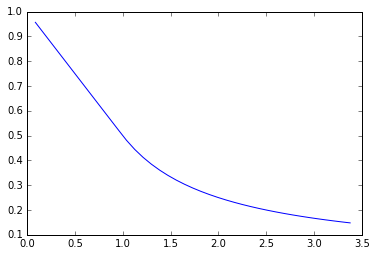

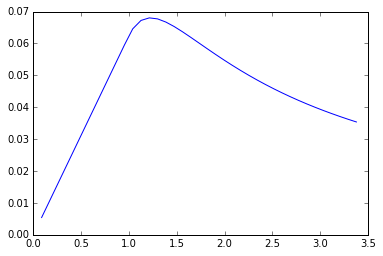

In [10]:
a=1
p=1
rijs = [np.array([x,x,x]) for x in  np.arange(0.05,2,0.05)]
RPYs = np.asarray([RotnePragerYamakawa(rij,a) for rij in rijs])
rs = [LA.norm(rij) for rij in rijs]
plt.plot(rs,RPYs[:,0,0])
plt.show()
plt.plot(rs,RPYs[:,0,2])

In [4]:
rtest = np.array([-5,5,0])
ptest = 1
atest = 1
RP = RotnePrager(rtest,ptest,atest)
R2pLR = longRangeR2p(rtest,ptest,atest)
R2pLRless = longRangeR2p(rtest,ptest,atest,2)
print('RP:',RP)
print('R2pLR:',R2pLR)
print('RP^-1:',LA.inv(RP))
print('diff:',(R2pLR)- (R2pLRless))

THIS CODE IS PROBABLY NOT CORRECT. USE getR() DEFINDE BELOW
THIS CODE IS PROBABLY NOT CORRECT. USE getR() DEFINDE BELOW
RP: [[ 0.07946112 -0.02625134  0.        ]
 [-0.02625134  0.07946112  0.        ]
 [ 0.          0.          0.05320979]]
R2pLR: [[ 1.40102569  0.17107833  0.17107833]
 [ 0.17107833  1.40102569  0.17107833]
 [ 0.17107833  0.17107833  1.40102569]]
RP^-1: [[ 14.1265791    4.66695661   0.        ]
 [  4.66695661  14.1265791    0.        ]
 [  0.           0.          18.79353571]]
diff: [[ 0.02325069  0.01050333  0.01050333]
 [ 0.01050333  0.02325069  0.01050333]
 [ 0.01050333  0.01050333  0.02325069]]


In [5]:
rtest = np.array([-2,2,2])
ptest = 1
atest = 1
RP = RotnePrager(rtest,ptest,atest)
print('RP:',RP)
print('R2pLR:',longRangeR2p(
        rtest,ptest,atest))
print('RP^-1:',LA.inv(RP))
print('R2pLR^-1:',LA.inv(R2pLR))

RP: [[ 0.14433757 -0.03458088 -0.03458088]
 [-0.03458088  0.14433757  0.03458088]
 [-0.03458088  0.03458088  0.14433757]]
THIS CODE IS PROBABLY NOT CORRECT. USE getR() DEFINDE BELOW
R2pLR: [[ 6.44534547  2.40092996  2.40092996]
 [ 2.40092996  6.44534547  2.40092996]
 [ 2.40092996  2.40092996  6.44534547]]
RP^-1: [[ 7.63532642  1.47573536  1.47573536]
 [ 1.47573536  7.63532642 -1.47573536]
 [ 1.47573536 -1.47573536  7.63532642]]
R2pLR^-1: [[ 0.73324977 -0.07979316 -0.07979316]
 [-0.07979316  0.73324977 -0.07979316]
 [-0.07979316 -0.07979316  0.73324977]]


In [6]:
c1 = 2
mmax = 5
c1pows = np.zeros(mmax)
c1pows[0] = 1;
for m in range(1,mmax):
    c1pows[m] = c1 * c1pows[m-1];
        
print(c1pows)


[  1.   2.   4.   8.  16.]


## Code from CConfiguration.h 

In [20]:
def getR(rij,a,p,mmax = 6,longRange=True,shortRange=True):
    r = LA.norm(rij)
    rrout = np.outer(rij,rij) / (r*r)
    lam = a/p
    lampow = [lam**i for i in range(12)]
    
    cg = (1+lam)**(-3);
    
    _g = np.zeros(3)
    _g[0] = 2 * lam**2 * cg;
    _g[1] = lam/5 * ( 1 + 7*lam + lam*lam ) * cg;
    _g[2] = 1/42 * ( 1 + lam*(18 - lam*(29 + lam*(18 + lam)))) * cg;

    f0 = 1;
    f1 = 3*lam;
    f2 = 9*lam;
    f3 = -4*lam+27*lampow[2]-4*lampow[3];
    f4 = -24*lam + 81*lampow[2] + 36*lampow[3];
    f5 = 72*lampow[2] + 243*lampow[3] + 72*lampow[4];
    f6 = 16*lam + 108*lampow[2]+ 281*lampow[3] + 648*lampow[4]+ 144*lampow[5];
    f7 = 1;
    f8 = 576*lampow[2] + 4848*lampow[3]+ 5409*lampow[4] + 4524*lampow[5] + 3888*lampow[6]+ 576*lampow[7];
    f9 = 1;
    f10 = 2304*lampow[2] + 20736*lampow[3]+ 42804*lampow[4]+ 115849*lampow[5]+ 76176*lampow[6] + 39264*lampow[7]+ 20736*lampow[8] + 2304*lampow[9];

    _fXm =  [f0,f2,f4,f6,f8,f10];
    ArrSize = 6;

    fy0 = 1;
    fy2 = 9/4*lam;
    fy4 = 6*lam+81/16*lampow[2]+ 18*lampow[3];
    fy6 = 4*lam + 54*lampow[2]+ 1241/64 *lampow[3 ]+ 81*lampow[4] + 72*lampow[5];
    fy8 = 279*lampow[2] + 4261/8*lampow[3] + 126369/256*lampow[4] - 117/8*lampow[5] + 648*lampow[6] + 288*lampow[7];
    fy10 = 1152*lampow[2] +7857/4*lampow[3] +98487/16*lampow[4] + 10548393/1024*lampow[5] +67617/8*lampow[6] - 351/2*lampow[7 ]+ 3888*lampow[8] + 1152*lampow[9];
    _fYm =  [fy0,fy2,fy4,fy6,fy8,fy10]

    for i in range(ArrSize):
        _fYm[i] /= (2*(1+lam))**(2*i)
        _fXm[i] /= (2*(1+lam))**(2*i)
    
    
    s = 2*r/(p/2 + a/2);
    c1 = pow(2/s, 2);
    c1pows = np.zeros(2*mmax)
    c1pows[0] = 1;
    for m in range(1,2*mmax):
        c1pows[m] = c1 * c1pows[m-1];
    Sum1 = - c1 * ( _g[2] + _g[1] );
    Sum2 = c1;
    
    for m in range(2,mmax):
        #print(Sum1)
        Sum1 += c1pows[m]/m * ( _g[2]/(m-1) - _g[1]);
        Sum2 += c1pows[m];
    
    Sum2 = Sum2 * _g[0];
    
    c3 = - ( _g[1] + _g[2] * ( 1 - c1 ) ) * np.log( 1 - c1 );
    c4 = ( _g[0]/(1-c1) - _g[0] +  2*c3  +  2*Sum1  +  Sum2 ) ;
    #print(_g[1],'\n++++++\n',_g[2])
        
    Sum3 = 0; Sum4 = 0;
    if longRange:
        for m in range(mmax):
            Sum3 += c1pows[m] * _fYm[m];
            Sum4 += c1pows[m] * _fXm[m];
    #print(c3,'\n',Sum1,'\n===',(Sum1+c3)/(rrout[0,0]*c4)) #This shows, that (Sum1+c3)/rrout[0,0]*c4) seems to always be small
    if shortRange==False:
        Sum1 = Sum2 = c3 = c4 = 0
    return np.identity(3) * (c3 + Sum1 + Sum3) +  rrout * (c4 + Sum4 - Sum3)

rij = np.array([1,0,1])
for n in range(4,7):
    print((getR(rij,1,1,n,True)),'\n--------------------')

[[ 1.50476427  0.          0.39242599]
 [ 0.          1.11233828  0.        ]
 [ 0.39242599  0.          1.50476427]] 
--------------------
[[ 1.51515959  0.          0.40466299]
 [ 0.          1.11049661  0.        ]
 [ 0.40466299  0.          1.51515959]] 
--------------------
[[ 1.52124467  0.          0.41130899]
 [ 0.          1.10993568  0.        ]
 [ 0.41130899  0.          1.52124467]] 
--------------------


# Test systematically, if I really need to calculate the small addition of c3 + Sum1, which almost cancel each other.

In [21]:
#TODO (Sum1+c3)/rrout[0,0]*c4) seems to always be small.
# Need to test it systematically for different s and lambda.
# -> first find s (i.e. distance) where it is maximal
# -> plot over lambda at this distance.
# then the other way around, too

# Calculate mobility from lubrication only for mobile tracer (p) and immobile spheres (a)

In [83]:
rvec = np.array([1,2,1])
p=1; a=1
RP2p = np.identity(6)
RP2p[0:3,3:] = RotnePrager(rvec, p, a=a)
RP2p[3:,0:3] = RotnePrager(rvec, p, a=a)
R_RP = LA.inv(RP2p)
print(R_RP[:3,:3])
print(getR(rvec,a=a,p=p))
print(getR(rvec,a=a,p=p)-R_RP[:3,:3])

[[ 1.03736013  0.02394792  0.01197396]
 [ 0.02394792  1.07328202  0.02394792]
 [ 0.01197396  0.02394792  1.03736013]]
[[ 1.05664609  0.05952689  0.02976345]
 [ 0.05952689  1.14593643  0.05952689]
 [ 0.02976345  0.05952689  1.05664609]]
[[ 0.01928596  0.03557897  0.01778948]
 [ 0.03557897  0.07265441  0.03557897]
 [ 0.01778948  0.03557897  0.01928596]]


In [79]:
def gettracerMlub(rijs,a,p):
    selfR = np.zeros([3,3])
    for rij in rijs:
        selfR += getR(rij,a=a,p=p)
    return LA.inv(selfR)
lam = 1
p = 1
a = lam*p
ras = []
# create particle test distance vectors - 1 rod
for i in range(1,10):
    ras.append([a*i,0,0])
    ras.append([0,a*i,0])
    ras.append([0,0,a*i])
rp = np.array([5,5,5])
rijs = [rp-ra for ra in ras]
print(rijs)
print(gettracerMlub(rijs[:1],a,p))

[array([4, 5, 5]), array([5, 4, 5]), array([5, 5, 4]), array([3, 5, 5]), array([5, 3, 5]), array([5, 5, 3]), array([2, 5, 5]), array([5, 2, 5]), array([5, 5, 2]), array([1, 5, 5]), array([5, 1, 5]), array([5, 5, 1]), array([0, 5, 5]), array([5, 0, 5]), array([5, 5, 0]), array([-1,  5,  5]), array([ 5, -1,  5]), array([ 5,  5, -1]), array([-2,  5,  5]), array([ 5, -2,  5]), array([ 5,  5, -2]), array([-3,  5,  5]), array([ 5, -3,  5]), array([ 5,  5, -3]), array([-4,  5,  5]), array([ 5, -4,  5]), array([ 5,  5, -4])]
[[ 0.99448146 -0.0042078  -0.0042078 ]
 [-0.0042078   0.99258795 -0.00525976]
 [-0.0042078  -0.00525976  0.99258795]]


### Compare to RP

In [74]:
def gettracerMRP(rvecs,a,p):
    dim = len(rvecs)
    M = np.zeros([3*dim,3*dim])
    for i in range(dim):
        for j in range(i,dim):
            ic = 3*i
            jc = 3*j
            if (i==j): 
                M[ic:ic+3,ic:ic+3] = p/a * np.identity(3)
            else:
                M[ic:ic+3,jc:jc+3] = RotnePrager(rvecs[i]-rvecs[j],a=a,p=p)
                M[jc:jc+3,ic:ic+3] = np.copy(M[ic:ic+3,jc:jc+3])
    M[0:3,0:3] =  np.identity(3)
    np.set_printoptions(threshold=100000)
    print((M.transpose() == M).all())
    return LA.inv(LA.inv(M)[:3,:3])
print(gettracerMRP(np.asarray([rp] + ras), p=p, a=a))

True
[[ 0.96144098 -0.00950846 -0.00950846]
 [-0.00950846  0.96144098 -0.00950846]
 [-0.00950846 -0.00950846  0.96144098]]


_________
_________
### Check if two-particle RP inverted is really just 3x3 identity matrix
To add  lubrication I have to add the two-particle resistance function $R_{2p}$ and subtract the long-range part that is already included in the RP tensor $R_{2p}^{RP}$ 
I assumed that for the subtraction of the long-range Part of the lubrication $R_{2p}^{RP}$  I just need to subtract the RP self mobility of the tracer, which, in my simulation, is just the identity matrix.

But, I need to verify that, if I invert the $6{\times}6$ two-particle RP tensor, I really just obtain the unit matrix as the self-resistance of the tracer, i.e. the upper left $3{\times}3$ sub matrix of the inverted $6{\times}6$ RP tensor.

### Turns out, this assertion was wrong

In [8]:
rvec = np.array([1,2,1])
p=1; a=1
RP2p = np.identity(6)
RP2p[0:3,3:] = RotnePrager(rvec, p, a=a)
RP2p[3:,0:3] = RotnePrager(rvec, p, a=a)
print('Rotne-Prager:\n',RP2p)
R_RP = LA.inv(RP2p)
print('Rotne-Prager-Inverted:\n',(R_RP))
R2p = getR(rvec,a,p=p,mmax=6,shortRange=True)
print('R2p:\n',R2p)
R_RP_tracer = np.copy(R_RP[:3,:3])

lubTracer = R2p - R_RP_tracer
print('lubMinusRP:\n',lubTracer)
print('lubShortRange\n',getR(rvec,a,p=p,mmax=6,longRange=False))


Rotne-Prager:
 [[ 1.          0.          0.          0.18073492  0.04677845  0.02338922]
 [ 0.          1.          0.          0.04677845  0.2509026   0.04677845]
 [ 0.          0.          1.          0.02338922  0.04677845  0.18073492]
 [ 0.18073492  0.04677845  0.02338922  1.          0.          0.        ]
 [ 0.04677845  0.2509026   0.04677845  0.          1.          0.        ]
 [ 0.02338922  0.04677845  0.18073492  0.          0.          1.        ]]
Rotne-Prager-Inverted:
 [[ 1.03736013  0.02394792  0.01197396 -0.18888751 -0.05509482 -0.02754741]
 [ 0.02394792  1.07328202  0.02394792 -0.05509482 -0.27152974 -0.05509482]
 [ 0.01197396  0.02394792  1.03736013 -0.02754741 -0.05509482 -0.18888751]
 [-0.18888751 -0.05509482 -0.02754741  1.03736013  0.02394792  0.01197396]
 [-0.05509482 -0.27152974 -0.05509482  0.02394792  1.07328202  0.02394792]
 [-0.02754741 -0.05509482 -0.18888751  0.01197396  0.02394792  1.03736013]]
-0.0231150793651
-0.0274388227513
-0.0278526418283
-0.02790

# Fit Inverted RP Stuff

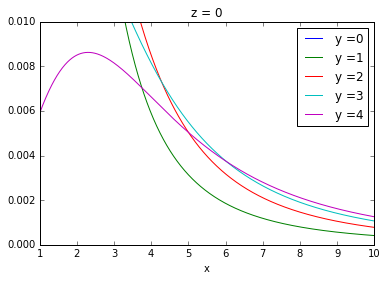

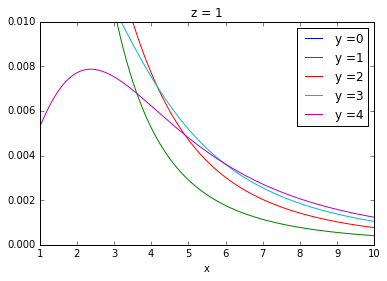

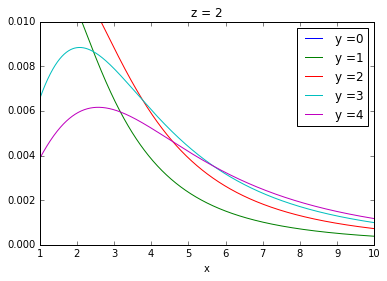

In [11]:
def getInvRP(rvec,p,a,i=0,j=0,full=False):
    RP2p = np.identity(6)
    RP2p[0:3,3:] = RotnePrager(rvec, p, a=a)
    RP2p[3:,0:3] = RotnePrager(rvec, p, a=a)
    RP2p[3:,3:] = np.identity(3) * p/a
    if full:
        return (LA.inv(RP2p)[:3,:3])
    return (LA.inv(RP2p)[:3,:3])[i,j]

rvec = lambda x,y,z: np.array([x,y,z])

getInvRR = np.vectorize(getInvRP)

p=1; a=1
xrange = np.arange((a+p)/2, 10,0.01)
for z in range(0,3):
    plt.figure(z)
    for y in range(0,5):
        RPparam = [getInvRP(rvec(x,y,z),p,a,1) for x in xrange ]
        plt.plot(xrange,RPparam,label='y =' + str(y))
    plt.title('z = ' + str(z))
    plt.ylim(0,.01)
    plt.xlabel('x')
    plt.legend()
    plt.show()



In [10]:
rij = rvec(1,2,1)
getInvRP(rij,p,a,full=True) / np.outer(rij,rij)

array([[ 1.03736013,  0.01197396,  0.01197396],
       [ 0.01197396,  0.2683205 ,  0.01197396],
       [ 0.01197396,  0.01197396,  1.03736013]])

### Find prefactors that only depend on the distance r

In [17]:
def getPrefactors(rij,p,a):    
    rr = np.outer(rij,rij) / rij.dot(rij)
    pref_rr = getInvRP(rij,p,a,0,1) / rr[0,1]   # This is correct!
    pref_I = (getInvRP(rij,p,a,0,0) - pref_rr * rr[0,0])
    return pref_I, pref_rr

#test if it works -- Yes!
rij = np.array([0.01,5,0])
a = 0.5; p = 1
# print(getInvRP(rij,p,a,full=True))
pI,prr = getPrefactors(rij,a,p)
print(getInvRP(rij,p,a,full=True) - np.identity(3)*pI - prr * np.outer(rij,rij))
print(getPrefactors(rij,a,p))
rij *=2; a *=2; p*=2
print(rij)
print(getPrefactors(rij,a,p))

[[ -8.10070223e-07  -4.05035111e-04   0.00000000e+00]
 [ -4.05035111e-04  -2.02517556e-01   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00  -2.22044605e-16]]
(1.0028440405175796, 0.0084382300783921883)
[  0.02  10.     0.  ]
(1.0028440405175796, 0.0084382300783921883)


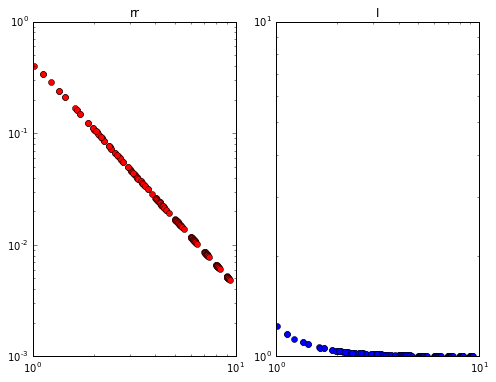

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(8, 6))
pI_store = []
prr_store = []
r_store = []
a=1
p=1
for x in np.arange(0.1,2,0.4):
    for y in np.arange(0.1,2,0.4):
        for z in np.arange((a+p)/2,10):
            vec = np.array([x,y,z])
            r = LA.norm(vec)
            pI,prr = getPrefactors(vec,a=a,p=p)
            ax1.loglog(r,prr,'ro')
            ax2.loglog(r,pI,'bo')
            pI_store.append(pI)
            prr_store.append(prr)
            r_store.append(r)
ax1.set_title('rr')
ax2.set_title('I')
plt.show()

### Power Law fits to rr prefactor

[]

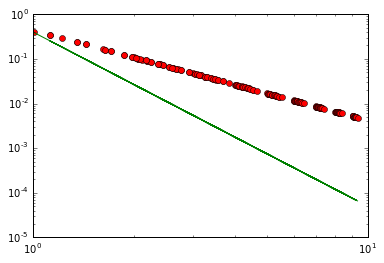

In [19]:
def fitres(r):
    r=np.array(r)
    return 0.4*r**np.log10(5e-5/0.4)

plt.loglog(r_store,prr_store,'ro')
plt.loglog(r_store,fitres(r_store),'-g')
plt.plot()

### What fits for I prefactor?
Looks like an exponential decrease. If I have a look at what the lubrication tensor looks like
\begin{equation}
 {A}_{ij} =   \hat{r} \hat{r} \left( X_{ij} - Y_{ij} \right) + {1} X_{ij} 
\end{equation}
the I part prefactor $X_{ij}$ is actually a polynomial 
$$X_{11}(s,\lambda) \propto \sum_{\substack{m = 2 \\ m \text{ even}}} P_m \left(\frac{2}{s}\right)^m$$

In [20]:
def fpoly(x, a, b, c, d, e, f, g, h):
    x = np.asarray(x)
    return a + b*x**-1 + c*x**-2 + d*x**-3 + e*x**-4 + f*x**-5 + g*x**-6 + h*x**-7

def fpow(x,a,b):
    return a * x**b

fitI, pcov = curve_fit(fpoly, r_store, pI_store)
fitrr, pcov = curve_fit(fpow, r_store, prr_store, p0=(0.4, np.log10(5e-5/0.4)))
print(fitI)
print(fitrr)

[ 0.9999458   0.00137231  0.12690828  0.07054874 -0.13716763  0.33595905
 -0.27998181  0.11912296]
[ 0.42512725 -1.97715673]


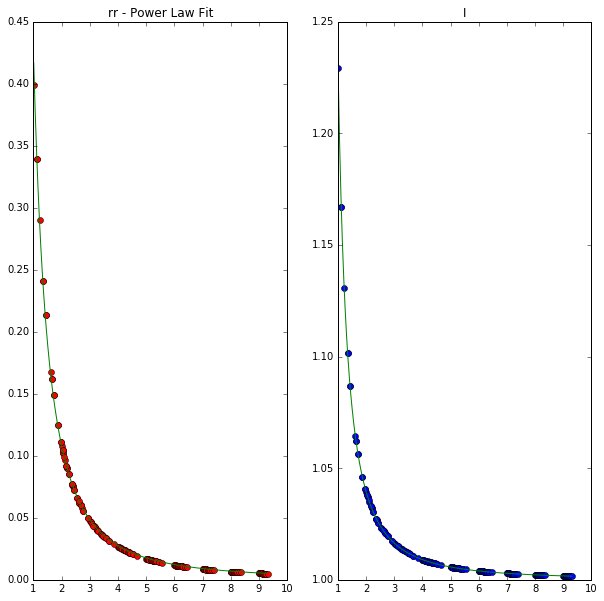

In [21]:
xs = np.arange(r_store[0],r_store[-1],0.05)
ysI = fpoly(xs, *fitI)
ysrr = fpow(xs, *fitrr)
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 10))
ax1.plot(r_store,prr_store,'ro')
ax1.plot(xs,ysrr,'g-')
ax2.plot(r_store,pI_store,'bo')
ax2.plot(xs,ysI,'g-')
ax1.set_title('rr - Power Law Fit')
ax2.set_title('I')
plt.show()

Finally test polynomial fit also with rr prefactor

[  7.35678362e-05  -1.91834439e-03   4.41809640e-01  -1.07872775e-01
   3.95238450e-01  -5.99041361e-01   5.66146248e-01  -2.90121862e-01] 
We can see  that, in accordance with the power law fit, the prefactor of the x**-4 term dominates.


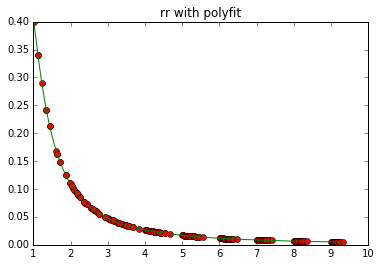

In [22]:
fitrrPoly, pcov = curve_fit(fpoly, r_store, prr_store)
ysrrPoly = fpoly(xs, *fitrrPoly)
plt.plot(r_store,prr_store,'ro')
plt.plot(xs,ysrrPoly,'g-')
plt.title('rr with polyfit')
print(fitrrPoly, '\nWe can see  that, in accordance with the power law fit, the prefactor of the x**-4 term dominates.')

Maybe even a tiny bit better than power law fit.

## Now I need to test with different a and p
### Rescaling the variables as in Jeffrey1984
\begin{equation}
s = \frac{2r}{a + p}, \quad \lambda = \frac{a}{p}
\end{equation}

In [29]:
def fitRPinv(a,p,plot=True,plotall=False):
    # First, we need to find the prefactors pI and prr of the identity Matrix I and the outer product rr
    # for different sphere distances r.
    pI_store = []
    prr_store = []
    s_store = []
    r_store = []
    gets = lambda r: 4*r/(a+p)
    lam = a/p 
    #TODO change this so simply an r array or something, since the results only depend on r not on the vector
    for x in np.arange(0.001,15*(a+p)/2,0.025*(a+p)):
        vec = np.array([x,0.001,(a+p)/2])
        r = LA.norm(vec)
        s = gets(r)
        pI,prr = getPrefactors(vec,a=a,p=p)
        pI_store.append(pI)
        prr_store.append(prr)
        r_store.append(r)
        s_store.append(s)
    if plotall and plot:
        f, (ax1, ax2) = plt.subplots(1, 2,figsize=(8, 6))
        ax1.loglog(r_store,prr_store,'ro')
        ax2.loglog(r_store,pI_store,'bo')
        ax1.set_title('rr')
        ax2.set_title('I')
        plt.show()
    # Then we need to fit the result. For now only a polyfit.
    fitI, pcov = curve_fit(fpoly, s_store, pI_store)
    fitrr, pcov = curve_fit(fpoly, s_store, prr_store)
    if plot:
        print(fitI)
        print(fitrr)
        xs = np.arange(s_store[0],s_store[-1],0.05)
        ysI = fpoly(xs, *fitI)
        ysrr = fpoly(xs, *fitrr)
        f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))
        ax1.plot(s_store,prr_store,'ro')
        line1 = ax1.plot(xs,ysrr,'g-')
        ax2.plot(s_store,pI_store,'bo')
        line2 = ax2.plot(xs,ysI,'g-')
        plt.setp([line1,line2], linewidth=3, color='g')
        ax1.set_title('rr')
        ax2.set_title('I')
        ax1.set_xlabel('s')
        ax2.set_xlabel('s')
        ax1.set_ylabel('prefactor of $rr$')
        ax2.set_ylabel('prefactor of $I$')
        plt.legend()
    return lam, fitI, fitrr

[  9.99968508e-01   1.97541771e-03   5.16264663e-01   5.29239975e-01
  -2.20219305e+00   1.11793437e+01  -1.89892837e+01   1.60670539e+01]
[  3.64154033e-05  -2.36276255e-03   1.74543185e+00  -7.05234387e-01
   5.71255802e+00  -1.78841084e+01   3.48633591e+01  -3.65622601e+01]
[  9.99973986e-01   1.63264652e-03   4.61759184e-01   4.38164660e-01
  -1.71898982e+00   9.28509061e+00  -1.57353483e+01   1.34549911e+01]
[ -9.47659171e-06   5.49715997e-04   1.48869661e+00   1.02852825e-01
  -3.42951338e-01   7.55110432e-03   2.86513332e-01  -1.08332616e+01]
[  9.99973986e-01   1.63264652e-03   4.61759184e-01   4.38164660e-01
  -1.71898982e+00   9.28509061e+00  -1.57353483e+01   1.34549911e+01]
[ -9.47659171e-06   5.49715997e-04   1.48869661e+00   1.02852825e-01
  -3.42951338e-01   7.55110432e-03   2.86513332e-01  -1.08332616e+01]
[  9.99968512e-01   1.97524326e-03   5.16267537e-01   5.29220519e-01
  -2.20214157e+00   1.11793404e+01  -1.89894769e+01   1.60672731e+01]
[  3.64225386e-05  -2.36313

/usr/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


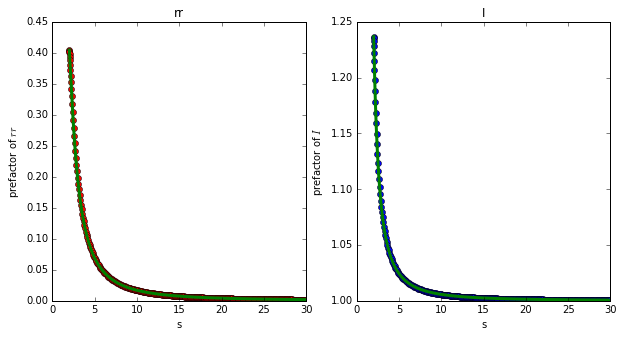

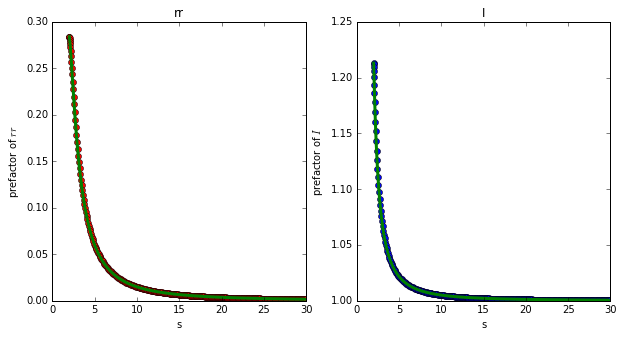

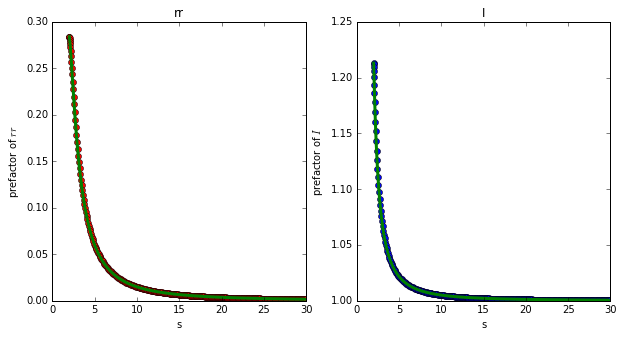

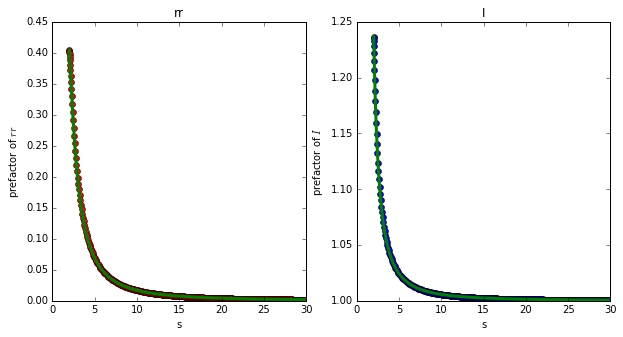

In [30]:
for a in range(1,3):
    for p in range(1,3):
        fitRPinv(a=a,p=p)

## Now I need to look for a fit function for the lambda dependency

In [21]:
p = 1
lams = []
rfitpIs = []
rfitprrs = []
for a in np.arange(0.1,10,0.1): #This creates lams = a, if p=1
    lam, rfitpI, rfitprr = fitRPinv(a=a,p=p,plot=False) # Fit in r, i.e. s, to obtain stützstellen for fit in lambda 
#     print(rfitpI,'\n------------------------\n')
    lams.append(lam)
    rfitpIs.append(rfitpI)
    rfitprrs.append(rfitprr)
rfitpIs = np.asarray(rfitpIs).T
rfitprrs = np.asarray(rfitprrs).T

### Try fit like before, since results seem to deviate towards small lambda
(looks bad)

[array([  1.00000729e+00,  -1.09999765e-04,   1.10842220e-04,
        -5.00133769e-05,   1.07967837e-05,  -8.82848230e-07,
        -1.72689252e-08,   3.76044928e-09]), array([ -4.56861474e-04,   6.91079786e-03,  -6.98745419e-03,
         3.17514319e-03,  -6.96444070e-04,   6.02097096e-05,
         5.08885704e-07,  -2.11025810e-07]), array([  3.39958313e-02,   1.74018292e+00,  -2.52653885e+00,
         1.89667117e+00,  -7.93558208e-01,   1.80370384e-01,
        -2.02425993e-02,   8.47987096e-04]), array([ -1.21927892e-01,   1.86260714e+00,  -1.90785841e+00,
         8.90566491e-01,  -2.07106622e-01,   2.13678408e-02,
        -4.92651948e-04,  -2.91294237e-05]), array([  8.83851596e-01,  -7.69103455e+00,   5.59988972e+00,
        -4.43484261e-01,  -9.54218475e-01,   3.92635008e-01,
        -5.70194242e-02,   2.72577243e-03]), array([ -2.55350416e+00,   3.97855951e+01,  -4.17427604e+01,
         2.04222497e+01,  -5.20332017e+00,   6.62803884e-01,
        -3.57998740e-02,   4.91064907e-04]

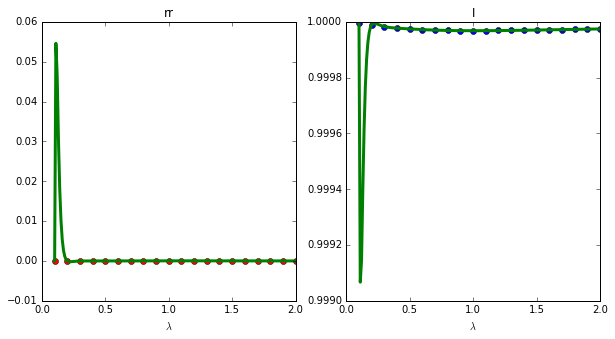

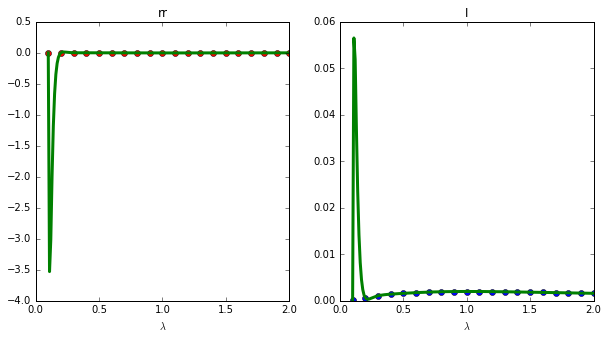

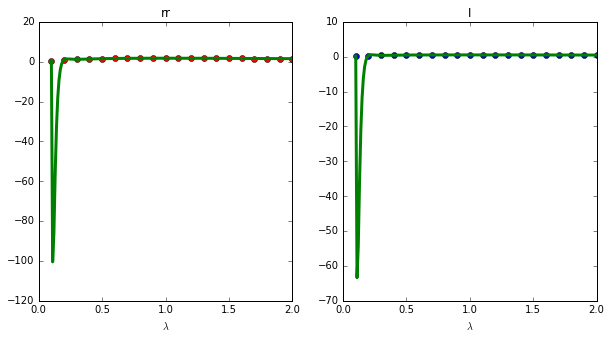

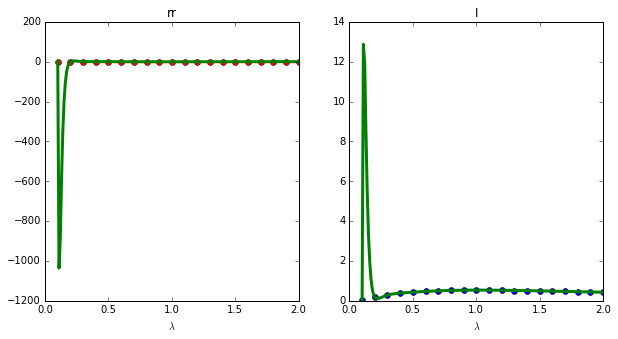

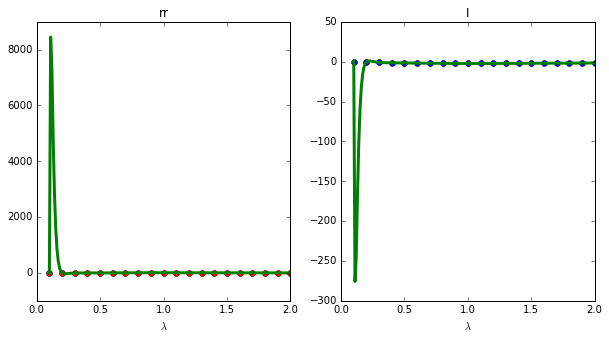

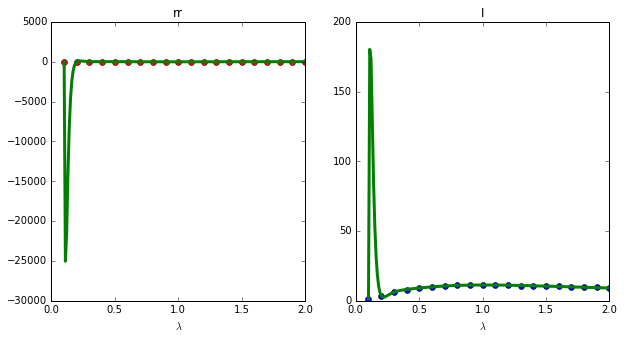

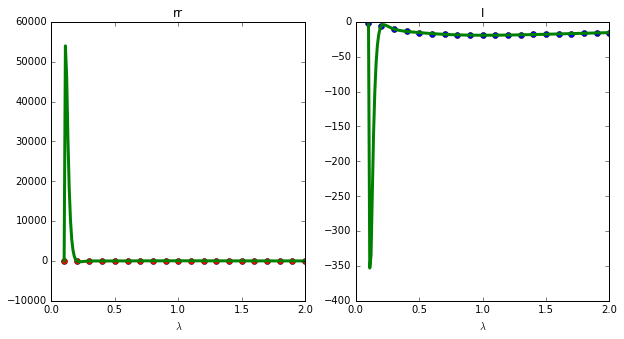

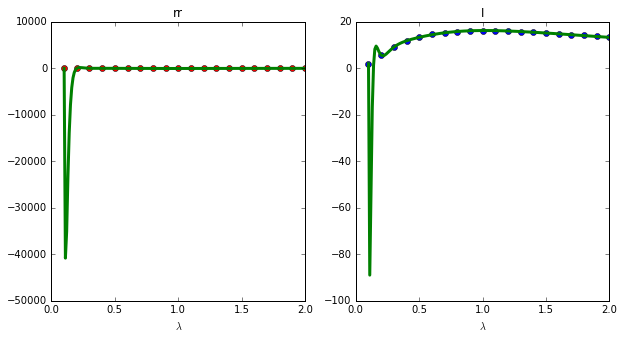

In [22]:
# Fit the prefactors p[i] with to polynomial function in lambda
lamfitpIs = []
lamfitprrs = []
for pI in rfitpIs:
    fit, pcov = curve_fit(fpoly, lams, pI)
    lamfitpIs.append(fit)
for prr in rfitprrs:
    fit, pcov = curve_fit(fpoly, lams, prr)
    lamfitprrs.append(fit)
print(lamfitpIs)
print(lamfitprrs)
xs = np.arange(lams[0],lams[-1],0.01)
polys = []
#Plot fit results
for i in range(len(lamfitprrs)):
    ysI = fpoly(xs, *lamfitpIs[i])
    ysrr = fpoly(xs, *lamfitprrs[i])
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))
    ax1.plot(lams,rfitprrs[i],'ro')
    line1 = ax1.plot(xs,ysrr,'g-')
    ax2.plot(lams,rfitpIs[i],'bo')
    line2 = ax2.plot(xs,ysI,'g-')
    plt.setp([line1,line2], linewidth=3, color='g')
    ax1.set_title('rr')
    ax2.set_title('I')
    ax1.set_xlabel(r'$\lambda$')
    ax2.set_xlabel(r'$\lambda$')
    ax1.set_xlim([0,2])
    ax2.set_xlim([0,2])



### Try polymer fit
looks ok - which is a surprise, since i forgot $(1 - \lambda)^{-2k}$ term, when I chose the fit function

[array([  5.63103106e-14,  -4.36222992e-12,   1.52918999e-10,
        -3.20727408e-09,   4.48338949e-08,  -4.40364318e-07,
         3.12116469e-06,  -1.61325867e-05,   6.06888485e-05,
        -1.63721544e-04,   3.06606487e-04,  -3.72629343e-04,
         2.45594141e-04,  -1.62965760e-05,  -8.36179570e-05,
         1.00000522e+00]), array([ -3.51904188e-12,   2.72633380e-10,  -9.55769465e-09,
         2.00462998e-07,  -2.80216545e-06,   2.75212450e-05,
        -1.95036677e-04,   1.00789519e-03,  -3.79042974e-03,
         1.02208650e-02,  -1.91271155e-02,   2.32152004e-02,
        -1.52480492e-02,   9.30983537e-04,   5.26864765e-03,
        -3.27879245e-04]), array([  2.49006555e-10,  -1.96109203e-08,   7.00848903e-07,
        -1.50400335e-05,   2.16159110e-04,  -2.19743513e-03,
         1.62714229e-02,  -8.90777031e-02,   3.62435291e-01,
        -1.09397731e+00,   2.43205545e+00,  -3.94007364e+00,
         4.59678522e+00,  -3.79563841e+00,   2.01543947e+00,
         1.37616617e-02]), arr

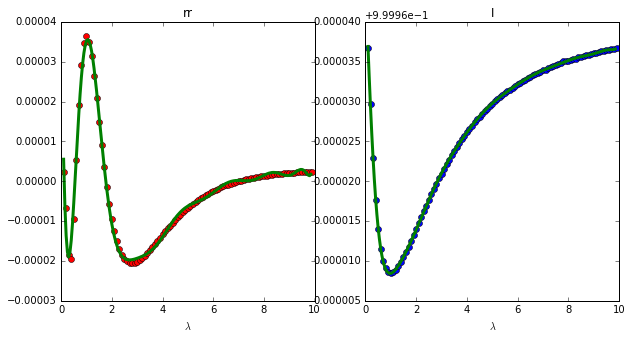

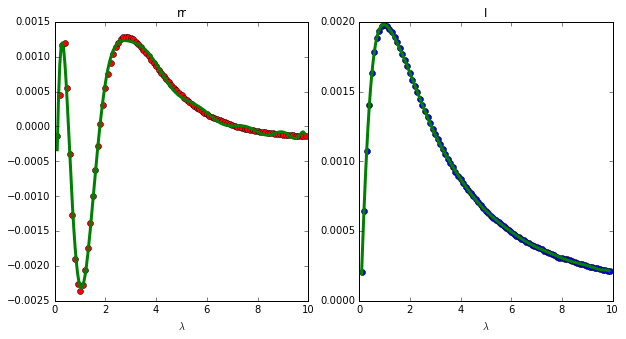

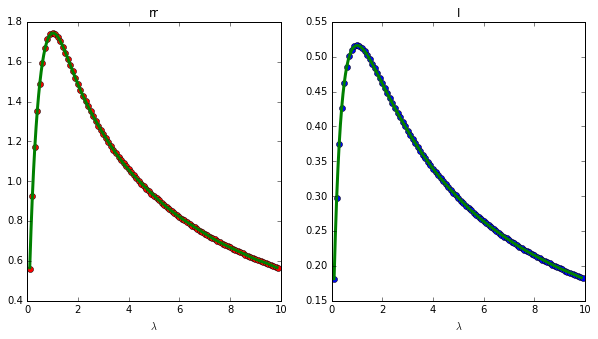

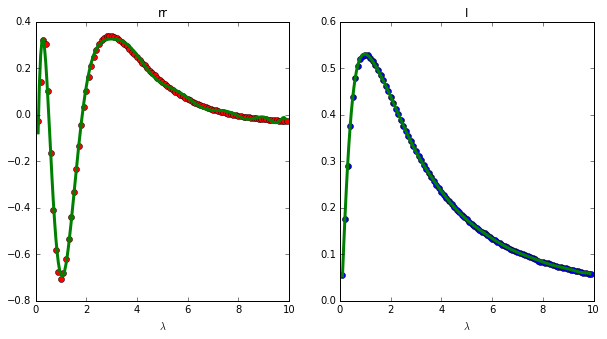

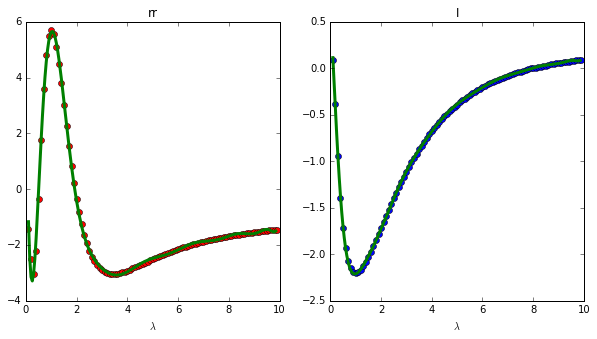

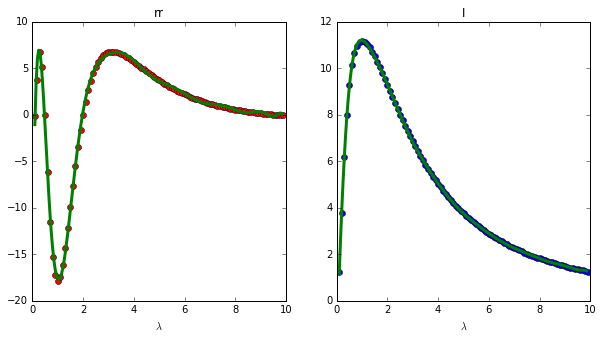

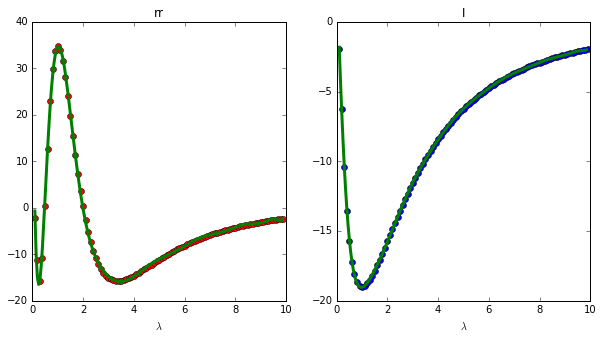

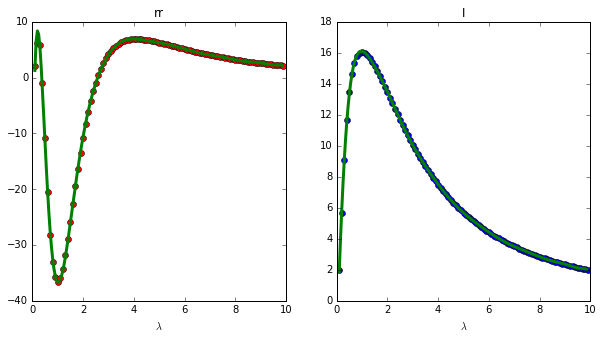

In [23]:
lamfitpIs = []
lamfitprrs = []
npoly = 15 # polymer order
for pI in rfitpIs:
    fit = np.polyfit(lams, pI, npoly)
    lamfitpIs.append(fit)
for prr in rfitprrs:
    fit = np.polyfit(lams, prr, npoly)
    lamfitprrs.append(fit)
print(lamfitpIs)
print(lamfitprrs)
xs = np.arange(lams[0],lams[-1],0.05)
polys = []
#Plot fit results
for i in range(len(lamfitprrs)):
    prr = np.poly1d(lamfitprrs[i])
    pI = np.poly1d(lamfitpIs[i])
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))
    ax1.plot(lams,rfitprrs[i],'ro')
    line1 = ax1.plot(xs,prr(xs),'g-')
    ax2.plot(lams,rfitpIs[i],'bo')
    line2 = ax2.plot(xs,pI(xs),'g-')
    plt.setp([line1,line2], linewidth=3, color='g')
    ax1.set_title('rr')
    ax2.set_title('I')
    ax1.set_xlabel(r'$\lambda$')
    ax2.set_xlabel(r'$\lambda$')


### Conclusion
The $\sum_m p_m(\lambda) s^{-m}$ and $\sum_n c_n \lambda^{-n}$ fit results look quite usable.

Try it for examplary $\lambda$

In [24]:
# Function that returns the prefactors for the polymer to calculate the RP resistance matrix for a certain lambda
def getps(lam):
    pIs = []; prrs = []
    for i in range(len(lamfitprrs)):
#         pIs.append(fpoly(lam, *lamfitpIs[i]))
#         prrs.append(fpoly(lam, *lamfitprrs[i]))
          prrs.append(np.poly1d(lamfitprrs[i])(lam))
          pIs.append(np.poly1d(lamfitpIs[i])(lam))
    return pIs, prrs

def getRPinvFIT(rvec,a,p):
    lam = a/p
    s = 4*np.sqrt(rvec.dot(rvec)) / (a+p)
    pIs, prrs = getps(lam)
    return np.identity(3) * fpoly(s, *pIs)  + np.outer(rvec,rvec)/rvec.dot(rvec) * fpoly(s, *prrs)


lambda =  2.61


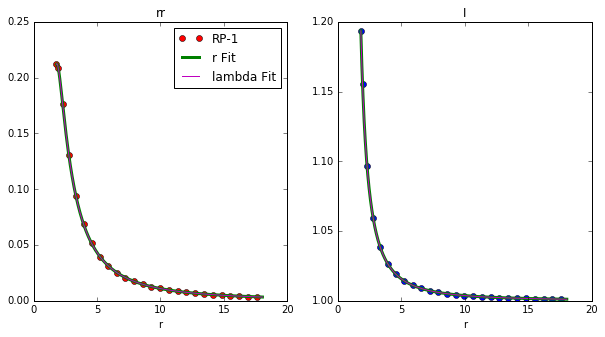

In [25]:
a = 2.61; p = 1
pI_store = []
prr_store = []
r_store = []
# Here I calculate the correct results, that come from inversion of the RP Tensor
for x in np.arange(0.01,5*(a+p),0.7):
    vec = np.array([x,0.01,(a+p)/2])
    r = LA.norm(vec)
    pI,prr = getPrefactors(vec,a=a,p=p)
    pI_store.append(pI)
    prr_store.append(prr)
    r_store.append(r)

# Here, I calculate the curve that results from fitting the above data
# Fit with polyfit, as in fitRPinv()
fitI, pcov = curve_fit(fpoly, r_store, pI_store)
fitrr, pcov = curve_fit(fpoly, r_store, prr_store)
xs = np.arange((a+p)/2,5*(a+p),0.01)
rfitysI = fpoly(xs, *fitI)   # calculate y values of fit over 
rfitysrr = fpoly(xs, *fitrr)
# stuff to plot double fit result
lam = a/p
s = 4*xs / (a+p)
pIs, prrs = getps(lam) # These parameters correspond to the fits with the reduced variables s and lambda
doublefitysI = fpoly(s, *pIs)
doublefitysrr = fpoly(s, *prrs)

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))
ax1.plot(r_store,prr_store,'ro',label='RP-1')
line1 = ax1.plot(xs,rfitysrr,'g-',label='r Fit')
ax1.plot(xs,doublefitysrr,'m',label='lambda Fit')
ax2.plot(r_store,pI_store,'bo',label='RP-1')
line2 = ax2.plot(xs,rfitysI,'g-',label='r Fit')
ax2.plot(xs,doublefitysI,'m',label='lambda Fit')
plt.setp([line1,line2], linewidth=3, color='g')
ax1.set_title('rr')
ax2.set_title('I')
ax1.set_xlabel('r')
ax2.set_xlabel('r')
ax1.legend()
print('lambda = ',lam)

In [26]:
getPrefactors(rij,a,p)

(1.003732117981649, 0.01097161148613892)

In [27]:
# Test for some different lambdas
lamtest = [0.21,0.83,2.21]
rvec = np.array([1,2,1])
for lam in lamtest:
    p = 1
    a = p * lam
    print('\n=======\n Fit:\n',getRPinvFIT(rvec,a=a,p=p))
    print('\n-------\n (RP)^-1:\n',getInvRP(rvec,p=p,a=a,full=True))
    print('\n-------\n (RP)^-1 - Fit:\n',getInvRP(rvec,p=p,a=a,full=True)-getRPinvFIT(rvec,a=a,p=p))


 Fit:
 [[ 1.00748243  0.00479783  0.00239891]
 [ 0.00479783  1.01467917  0.00479783]
 [ 0.00239891  0.00479783  1.00748243]]

-------
 (RP)^-1:
 [[ 1.00749177  0.00480064  0.00240032]
 [ 0.00480064  1.01469273  0.00480064]
 [ 0.00240032  0.00480064  1.00749177]]

-------
 (RP)^-1 - Fit:
 [[  9.34224791e-06   2.81521143e-06   1.40760572e-06]
 [  2.81521143e-06   1.35650651e-05   2.81521143e-06]
 [  1.40760572e-06   2.81521143e-06   9.34224791e-06]]

 Fit:
 [[ 1.03068515  0.01978612  0.00989306]
 [ 0.01978612  1.06036434  0.01978612]
 [ 0.00989306  0.01978612  1.03068515]]

-------
 (RP)^-1:
 [[ 1.03069233  0.01978408  0.00989204]
 [ 0.01978408  1.06036845  0.01978408]
 [ 0.00989204  0.01978408  1.03069233]]

-------
 (RP)^-1 - Fit:
 [[  7.17778424e-06  -2.04234979e-06  -1.02117490e-06]
 [ -2.04234979e-06   4.11425956e-06  -2.04234979e-06]
 [ -1.02117490e-06  -2.04234979e-06   7.17778424e-06]]

 Fit:
 [[ 1.08904099  0.04908932  0.02454466]
 [ 0.04908932  1.16267498  0.04908932]
 [ 0.024

### Looks good!
Now, I need to extract the fit results and feed it into my simulation to avoid having to invert the two-particle RP Tensor.
Alternatively, I could write a script to calculate the inverted RP Tensor fit parameters for a certain alpha in the beginning of the simulation...

In [97]:
# This code writes r fit result to a file.
import sys
# def fitToFile(lam):
# p = float(sys.argv[1])
# a = float(sys.argv[2])
a = 1
p = 3
Fitfile = open('rfit.txt','w')
lam, rfitpI, rfitprr = fitRPinv(a=a,p=p,plot=False)
for i in range(len(rfitpI)):
    Fitfile.write( str(rfitpI[i]) + ' \t' + str(rfitprr[i]) + '\n' )
Fitfile.close()

In [106]:
import sys
test = open('test/test.txt','w')
for a in range(3):
    test.write(str(a) )
test.close()

FileNotFoundError: [Errno 2] No such file or directory: 'test/test.txt'